Modéle LSTM 


Imports


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import json
import re
import pickle
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # utilisation cpu ou gpu selon la machine
print(f"Utilisation du périphérique : {device}")

PATH = r"yelp_academic_reviews4students.jsonl"
VOCAB_SIZE = 20000
MAX_LEN = 150
EMBED_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 64
NUM_CLASSES = 5 
EPOCHS = 40

Utilisation du périphérique : cuda


Préparation données 

In [17]:
data = []
with open(PATH, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))
df_full = pd.DataFrame(data)

# Mapping : 1 étoile -> index 0, ..., 5 étoiles -> index 4 (Requis par PyTorch)
df_full['label'] = df_full['stars'].apply(lambda x: int(x - 1))

N_TOTAL = 20000
N_PER_CLASS = N_TOTAL // 5  # Soit 4000 par classe

# Équilibrage strict avec échantillonnage limité
dfs = []
for i in range(5):
    # On sélectionne les données de la classe i
    class_data = df_full[df_full['label'] == i]
    # On en pioche exactement N_PER_CLASS
    sampled_data = class_data.sample(N_PER_CLASS, random_state=42)
    dfs.append(sampled_data)

df = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Équilibrage terminé : {N_PER_CLASS} avis par classe (Total: {len(df)})")

Équilibrage terminé : 4000 avis par classe (Total: 20000)


Tokenisation manuelle

In [18]:
def clean(t):
    # Nettoyage : minuscules, suppression ponctuation
    return re.sub(r"[^a-z\s']", " ", str(t).lower()).split()

X_raw = [clean(t) for t in df['text']]
y = df['label'].values

# Split 80/20
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, stratify=y)

# Construction du vocabulaire sur le train uniquement
all_words = [word for text in X_train_raw for word in text]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_words).most_common(VOCAB_SIZE-2))}
vocab["<PAD>"] = 0
vocab["<OOV>"] = 1

def encode(text):
    encoded = [vocab.get(w, 1) for w in text][:MAX_LEN]
    return encoded + [0] * (MAX_LEN - len(encoded))

X_train = torch.tensor([encode(t) for t in X_train_raw])
X_test = torch.tensor([encode(t) for t in X_test_raw])
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

Architecture LSTM

In [19]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        # hidden_dim * 2 car Bidirectionnel
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # Concaténation des derniers états cachés des deux directions
        out = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(out))

model = LSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Entrainement

In [20]:
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Époque {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f}")

Époque 1/40 - Loss: 1.5085
Époque 2/40 - Loss: 1.3060
Époque 3/40 - Loss: 1.1675
Époque 4/40 - Loss: 1.1076
Époque 5/40 - Loss: 0.9774
Époque 6/40 - Loss: 0.8551
Époque 7/40 - Loss: 0.7569
Époque 8/40 - Loss: 0.6502
Époque 9/40 - Loss: 0.5648
Époque 10/40 - Loss: 0.4747
Époque 11/40 - Loss: 0.4263
Époque 12/40 - Loss: 0.3575
Époque 13/40 - Loss: 0.3025
Époque 14/40 - Loss: 0.2722
Époque 15/40 - Loss: 0.2299
Époque 16/40 - Loss: 0.2227
Époque 17/40 - Loss: 0.1768
Époque 18/40 - Loss: 0.1439
Époque 19/40 - Loss: 0.1191
Époque 20/40 - Loss: 0.1013
Époque 21/40 - Loss: 0.0927
Époque 22/40 - Loss: 0.0883
Époque 23/40 - Loss: 0.0788
Époque 24/40 - Loss: 0.0760
Époque 25/40 - Loss: 0.0850
Époque 26/40 - Loss: 0.0804
Époque 27/40 - Loss: 0.0573
Époque 28/40 - Loss: 0.0647
Époque 29/40 - Loss: 0.0979
Époque 30/40 - Loss: 0.2164
Époque 31/40 - Loss: 0.0584
Époque 32/40 - Loss: 0.0343
Époque 33/40 - Loss: 0.0488
Époque 34/40 - Loss: 0.0504
Époque 35/40 - Loss: 0.0247
Époque 36/40 - Loss: 0.0163
É

Evaluation



--- Rapport LSTM 5 classes ---
              precision    recall  f1-score   support

    1 étoile       0.64      0.57      0.60       800
   2 étoiles       0.39      0.50      0.44       800
   3 étoiles       0.38      0.41      0.40       800
   4 étoiles       0.44      0.37      0.40       800
   5 étoiles       0.62      0.55      0.58       800

    accuracy                           0.48      4000
   macro avg       0.49      0.48      0.48      4000
weighted avg       0.49      0.48      0.48      4000


--- Résultats de l'évaluation ---
eval_loss: 3.6098
eval_accuracy: 0.4810


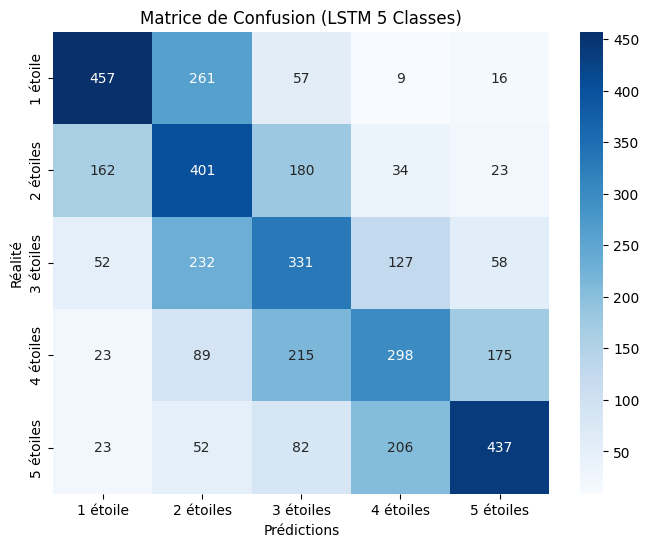

In [21]:
# --- ÉVALUATION ET GÉNÉRATION DES PRÉDICTIONS ---
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=False)
model.eval()

eval_loss = 0
correct = 0
total = 0
all_preds = [] # On initialise la liste ici pour corriger l'erreur

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        
        # 1. Calcul de la perte pour eval_results
        loss = criterion(outputs, labels)
        eval_loss += loss.item()
        
        # 2. Récupération des prédictions pour le rapport
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy()) # On remplit la liste
        
        # 3. Calcul de l'accuracy pour eval_results
        correct += (preds == labels).sum().item()
        total += labels.size(0)

# --- AFFICHAGE DU RAPPORT (Ne causera plus d'erreur) ---
target_names = ['1 étoile', '2 étoiles', '3 étoiles', '4 étoiles', '5 étoiles']
print("\n--- Rapport LSTM 5 classes ---")
print(classification_report(y_test.cpu().numpy(), all_preds, target_names=target_names))

# --- DICTIONNAIRE DE RÉSULTATS (Format demandé) ---
eval_results = {
    "eval_loss": eval_loss / len(test_loader),
    "eval_accuracy": correct / total
}

print("\n--- Résultats de l'évaluation ---")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")
    
# Matrice de confusion
cm = confusion_matrix(y_test.cpu().numpy(), all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prédictions')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion (LSTM 5 Classes)')
plt.show()

Sauvegarde du modèle et du Vocabulaire

In [22]:
# Sauvegarde des poids
torch.save(model.state_dict(), "lstm_model_5classes.pth")

# Sauvegarde du vocabulaire (Indispensable pour l'inférence plus tard)
with open("vocab_5classes.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("Modèle et vocabulaire sauvegardés.")

Modèle et vocabulaire sauvegardés.
